# Zillow Regression Project                     
### *Presented by: Cristina Lucin*

____

## Project Overview

### This project is designed to identify important features and build a regression model to predict tax-assessed property value for single home properties. This report uses 'cost' or 'value' to refer to a home's tax assessed value.

_______

## Goals

Create deliverables:
- READ ME
- Final Report
- Functional wrangle.py, explore.py, and model.py files
- Acquire Zillow data from the Codeup database using functions located in Wrangle file
- Prepare and split the data
- Explore the data and define hypotheses, running appropriate statistical tests to accept or reject each null hypothesis
- Create a baseline model in predicting home cost and document the Root Mean Square Error (RMSE)
- Fit and train three (3) regression models to predict cost on the train dataset
- Evaluate the models by comparing their performance on train and validation data
- Select the best model and evaluate it on testing data
- Develop and document findings, takeaways, recommendations and next steps

In [1]:
#Get Imports
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SK Learn
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

#Stats
from scipy.stats import pearsonr, spearmanr, kruskal, levene
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

#My imports
import wrangle as w
import env
import model as m
import explore as e

_________

## Data Acquisition

- Data acquired from Codeup Database (11/14/2022)
- It contained 52,442 rows and 10 columns before cleaning
- Each row represents a single-family home located within Los Angeles, Orange, or Ventura County, California.
- Each column represents a feature of those homes

In [2]:
#Get the data
df = w.get_zillow_data()

### Data Dictionary

| Feature | Definition |
| --- | --- |
| Tax_Value | Value of a property computed by county utilizing tax data (TARGET VARIABLE)
| Bedrooms | Number of bedrooms listed for a property|
| Bathrooms | Number of bathrooms listed for a property |
| Square_Feet | Total square footage listed for a property |
| FIPS | Codes associated with US Counties |
| Latitude | Latitude associated to a property location |
| Longitude | Longitude associated to a property location |
| Lot_Size | Total area of a property lot |
| Year_Built | Year a property was constructed |
| Transaction_Date | Date a property was bought/sold |
| Parcel_ID | Unique identifying number associated with a property by Zillow |
| Home_Age | Feature-engineered column assigning an integer as "home age" by subtracting year built from 2017
| County| Feature-engineered column indicating the county a property is located in, utilizing FIPS code

## Preparing the Data

### Prepare Actions:

* Renamed columns to promote readability
* Checked for nulls and NaN values in the data, dropped Null Values stored as whitespace
* Checked that column data types were appropriate, converting data types to facilitate exploration and modeling
* Removed outliers utilizing the IQR method with a k value of 3
* Total data loss from removing outliers and null values was 4.8%

### Feature Engineering

* Mapped FIPS data to correspond to their appropriate county (LA, Orange, Ventura)
* Created a new column 'home_age' using year_built, casted as an integer

In [3]:
#Prepare the data for exploration using a function called from my 
#Get Clean data
df = w.clean_zillow(df)
df.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
0,4,3.5,3100.0,6059,33634931.0,-117869207.0,4506,1998,1023282,2017-01-01,14297519,Orange,19
1,2,1.0,1465.0,6111,34449266.0,-119281531.0,12647,1967,464000,2017-01-01,17052889,Ventura,50


### Data Splitting

* **Split data into train, validate and test (approx. 75/12.5/12.5), stratifying on 'tax_value'**

In [4]:
train, validate, test = w.train_validate_test_split(df)
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


_____

# Exploration

## Target Variable: Tax Value

In [6]:
#Descriptive Statistics for target variable
round(train.tax_value.describe(),2)

count      34937.00
mean      430893.29
std       331310.63
min         1000.00
25%       186636.00
50%       357258.00
75%       576492.00
max      1827450.00
Name: tax_value, dtype: float64

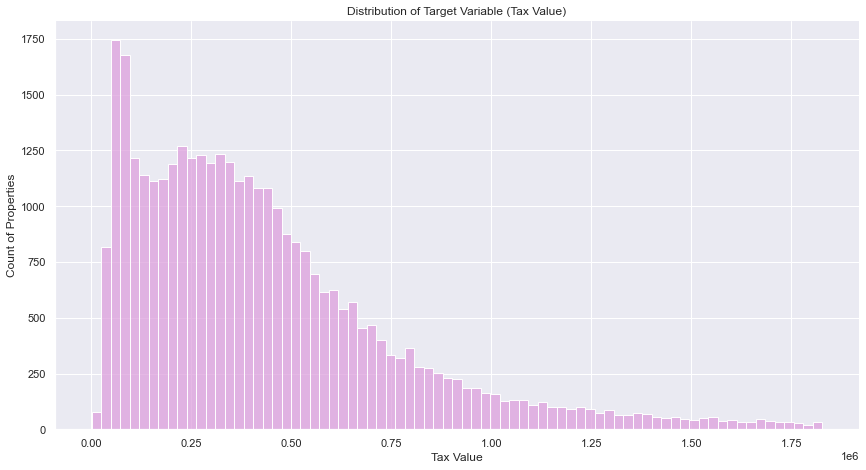

In [7]:
#Insert visualization of target variable (Viz 1)
e.target_viz(train)

## Question 1: Does property location impact home value?

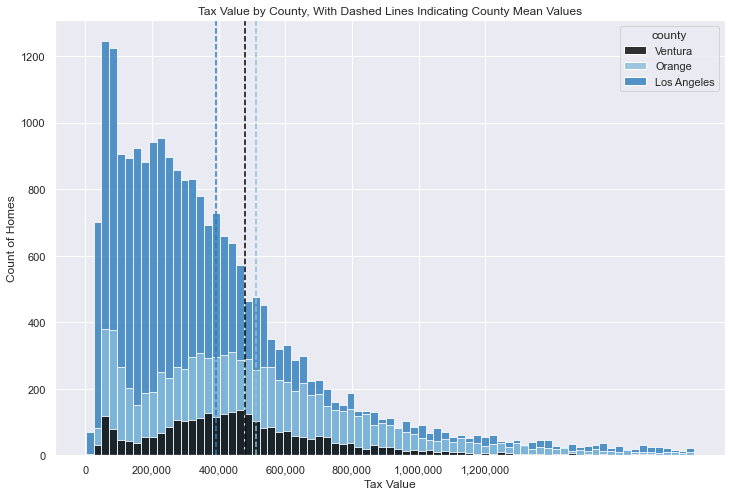

In [8]:
#Import visualization for home value
e.county_viz(train)

#### Homes in LA county are significantly less valuable than homes in Orange or Ventura counties. However, the variation of home values within LA couty are wide. LA county contains approximately 90 cities. Even with some outliers removed, the range of median home values within LA county in this data set is nearly 1.8 million. This is reflective of the diversity within LA County, which contains one of the nation's most expensive Zip Codes: Beverly Hills 90210, which in 2021 had a median home prices of 4.1 million (6th most expensive zip code in the nation). In comparison, one of the poorest cities in LA county, Compton, had a median home value of 355,200.

#### Taking this into consideration, I formulated a hypothesis that homes in LA county would be have a different value than homes located in Orange or Ventura county:

Hypotheses:

$H_0$: **Properties located in LA County and properties outside of LA County have the same tax value**

$H_a$: **Properties located in LA County and properties outside of LA County have different mean tax values.**

* I used a 95% confidence interval
* The resulting alpha value is .05


In [9]:
#Perform Kruskal-Wallis test
e.get_kruskal_county(train)

KruskalResult(statistic=1436.0241360646417, pvalue=0.0)

#### Since the P value is less than our alpha (0.05), we can reject the null hypothesis and say that there is a significant difference in  properties in LA County and properties in Ventura or Orange County, with respect to tax value.

# Question 2/3: Does an increase in bedrooms/bathrooms also increase property tax value? Are bedrooms or bathrooms a better predictor of home value?

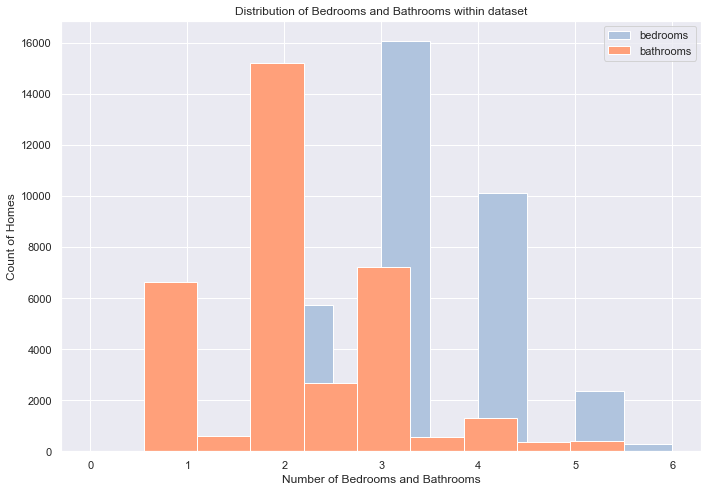

In [10]:
##Visualize bedrooms/bathrooms using a function from my explore file
e.get_hist_bedbath(train)

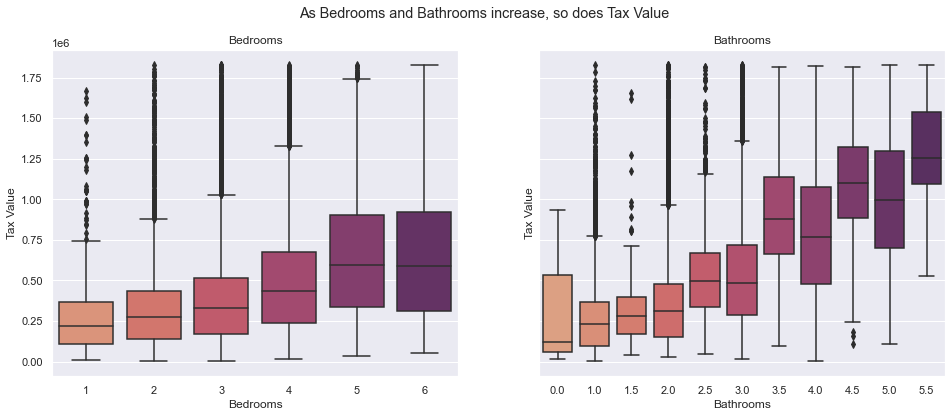

In [11]:
#Visualize bedrooms and bathrooms vs. Tax Value
e.bed_bath_viz(train)

#### After removing outliers, this data had a maximum of six bedrooms, and five and a half bathrooms. Half and three-quarter bathrooms led me to treat bathrooms as a continuous variable. For both bedrooms and bathrooms, an analysis of visualization shows that as bedrooms and bathrooms increase, the actual tax value of a property increases:

### Bedrooms

Hypotheses:

$H_0$: **Number of bedrooms has no relationship with tax value**

$H_a$: **Number of bedrooms has a relationship with tax value**

* I used a 95% confidence interval
* The resulting alpha value is .05

In [13]:
#Run statistical test comparing bedroom count mean tax value
e.kruskal_bedrooms(train)

KruskalResult(statistic=2437.4735759228015, pvalue=0.0)

#### Since the P value is less than our alpha (0.05), we can reject the null hypothesis and say that there is a significant difference between properties with different numbers of bedrooms, with respect to tax value.

### Bathrooms

Hypotheses:

$H_0$: **Number of bathrooms has no relationship with tax value**

$H_a$: **Number of bathrooms has a relationship with tax value**

* I used a 95% confidence interval
* The resulting alpha value is .05

In [14]:
#Running Spearman's R because my features and target are not normal
corr, p = spearmanr(train.bathrooms, train.tax_value)
corr, p
print(f'Test statstic is:{corr.round(2)}, p-value is:{p}')

Test statstic is:0.44, p-value is:0.0


#### Since the P value is less than our alpha (0.05), we can reject the null hypothesis and say that there is a positive relationship between number of bathrooms and tax value

### To compare the two, I conducted a two-sample, one-tailed t-test comparing properties with over the median number of bathrooms and under the median number of bedrooms with properties having under the median number of bathrooms/over the median number of bedrooms. These two groups were then compared using the target variable, tax value:

Hypotheses:

$H_0$: **Homes with above median bathrooms and below median bedrooms have a lower or equal tax value than homes with below median bathrooms and above median bedrooms**

$H_a$: **Homes with above median bathrooms and below median bedrooms have greater tax value than homes with below median bathrooms and above median bedrooms**

* I used a 95% confidence interval
* The resulting alpha value is .05

In [15]:
#Run the test
e.get_ttest_bedbath(train)

Test statistic: 9.26, P-Value: 3.9030547897685863e-19


### Based on this test result, we can conclude that homes that homes with more bedrooms, but less bathrooms are generally LESS valuable than homes with bedrooms under the median, but have more bathrooms than the median. This could mean that buyers value number of bathrooms higher than number of bedrooms. 

# Question 4: Does home age impact tax value?

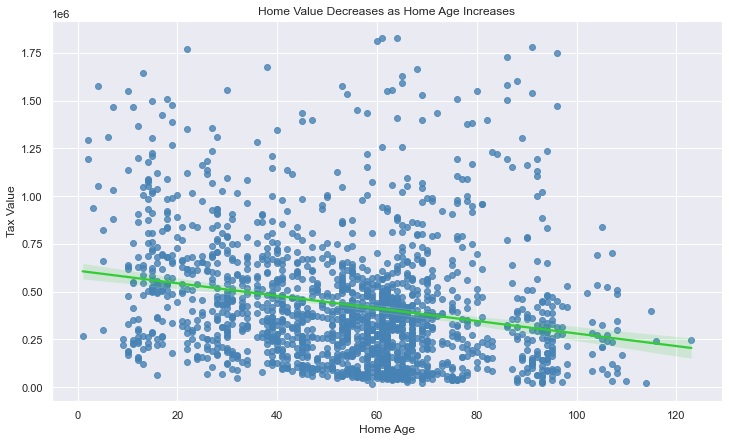

In [16]:
#Make Visualization from Home Age vs. Tax Value
e.home_age_viz(train)

Hypothesis:

$H_0$: **There is no relationship between home age and tax value**

$H_a$: **There is a relationship between home age and tax value**

* I used a 95% confidence interval
* The resulting alpha value is .05

In [17]:
#Running Spearman's R test to compare home age and tax value
corr, p = spearmanr(train.home_age, train.tax_value)
print(f'Test Statistic: {corr}, P-Value: {p}')

Test Statistic: -0.26291043249416846, P-Value: 0.0


#### Since the P value is less than 0.05, we can reject the null hypothesis and say that there is a relationship between home age and tax value. Wherein, as home age increases, there is a decrease in tax value

### Some buyers may shy away from older homes, as they typically require more maintainance and could require higher-cost repairs such as roof replacement, heating/cooling system replacement, or foundation work. 

_______

## Exploration Summary

* All features that I examined in this dataset had significant relationships with the target variable of "tax_value"
* Location matters, as properties within LA county and those without showed significant differences
* As bedrooms and bathroom count increases, tax value increases
* Home age, which was feature engineered, was significantly related to tax value
* More time to explore this data could yield greater results in exploration, specifically within location. Examining properties by Zip Code is likely to yield more results

## Features not taken into modeling:

* FIPS: Translated into County Data, not needed in modeling
* Latitude/Longitude: Could be valuable for future examination of location (neighborhood, zip code)
* Lot Size: Significant to Tax Value, but Square Feet appears to be a larger driver
* Year Built: Feature engineered into home age 
* Transaction Date: Small potential impact to home value 
* Parcel ID: Unique property identifier not needed for modeling

# Modeling

### Goal: 
* Develop several regression models utilizing features in this dataset
* Evaluates models based on Root Mean Squared Error (RMSE) and R^2 Value
* Select the model that best predicts tax-value

## Model 1 (MVP): Using bedrooms, bathrooms, and square feet 

#### For my MVP model, I only included bedrooms, bathrooms and square feet in my model. I utilized a min-max scaler and ordinary least squares (OLS) regression. This was it's performance:

In [18]:
#Run MVP model and get results from function in model.py
m.get_mvp_model_with_results(train,validate,test)

Explained Variance=0.324, Baseline Model RMSE: 331305.893, MVP model RMSE is:272435.766


#### This model has an R2 of 0.32, with a 17% reduction in RMSE

## Model 2 and Model 3: Lasso-Lars and Polynomial Features (3rd Degree) utilizing the following features:
* Bedrooms
* Bathrooms
* Square Feet
* Home Age
* LA County

#### The choice of modeling features involved using recursive feature elimination (RFE) and Select K-Best to identify the features that gave the most weight to a potential regression model. These models were evaluated utilizing bedrooms and bathrooms separately, due to their strong relationship to each other, but resulted in higher RMSE scores than those models with both included. More features were likely to further reduce RMSE, but with a risk of overfitting. 

____

In [19]:
#prep for modeling
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model_prep(train,validate,test)

In [20]:
#Run and evaluate baseline, Lasso_Lars and Polynomial Features 3rd Degree
m.evaluate_models(X_train, y_train, X_validate, y_validate)

,model,rmse_train,r2_train,rmse_val,r2_val
0,baseline_mean,331305.893220,0.000000,334300.072942,0.000000
1,"LarsLasso, alpha 1",283242.026519,0.269102,285178.706960,0.272230
2,Polynomial Features 3rd Degree,264647.536769,0.361954,266112.338620,0.366302


# Model Evaluation 

### Based on the above results, I chose a Polynomial Features (3rd Degree) model to predict property tax-value. I chose this model based on its RMSE score compared to other models, as well as its R2 score and performance on Training and Validation data. I then evaluated this model on my test data:

In [21]:
#prep for modeling
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model_prep(train,validate,test)

In [22]:
#Evaluating this model and train, validate, AND test
m.evaluate_model_test(X_train, X_validate, X_test, y_train, y_validate, y_test)

,train,validate,test
rmse,264647.536769,266112.338620,266284.272457
r2,0.361954,0.366302,0.361241


# Conclusion

### My model reduced RMSE and increase R2 score from both the baseline and MVP model. Compared to baseline RMSE (331,306), my chosen model of Polynomial Features (3rd Degree) reduced RMSE by 65,022, giving an error reduction of 20% from the baseline. Compared to my MVP model, my chosen model improved R2 score to 0.36.

___

# Recommendations

* Continuing feature engineering for location. Classification of properties by Zip Code is likely to provide even stronger drivers of tax value. For properties in this dataset, a separation by county
* Obtaining data of last transaction price would likely include a large predictor of tax value

____

# Next Steps

* Including more features into modeling without overfitting a model
* Utilizing chosen features with models better suited to fit the skewed data within the Zillow dataset

______